In [1]:
import numpy as np
import os
import pandas as pd
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

%pylab inline
%config InlineBackend.figure_formats = ['retina']

from collections import OrderedDict

import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, fbeta_score

import warnings
warnings.simplefilter(action='ignore')

import imblearn.over_sampling

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer, OneHotEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


### Baseline Model

In [2]:
base_train = pd.read_csv("../data/application_train.csv")

In [3]:
X_base_train = base_train.drop(columns=['TARGET'])
num_features = X_base_train.select_dtypes('number').columns.values
X_base_train = X_base_train[num_features]
y_base_train = base_train.TARGET
print('X_base shape: ', X_base_train.shape)
print('y_base shape: ', y_base_train.shape)

X_base shape:  (307511, 105)
y_base shape:  (307511,)


In [4]:
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base_train, y_base_train, 
                                                                        test_size=0.2, random_state=42)

#features columns
features = list(X_base_train.columns)

#test set

#SimpleImputer wirth strategy = median
imputer = SimpleImputer(strategy='median')

#Scale the features
scaler = StandardScaler()

#Fit on the training data

#Imputer
imputer.fit(X_base_train)
X_base_train = imputer.transform(X_base_train)
X_base_test = imputer.transform(X_base_test)


print('X_train shape: ', X_base_train.shape)
print('X_test shape: ', X_base_test.shape)

X_train shape:  (246008, 105)
X_test shape:  (61503, 105)


In [5]:
lr_base = LogisticRegression(solver='liblinear') 
lr_base.fit(X_base_train, y_base_train)

LogisticRegression(solver='liblinear')

In [6]:
print('Baseline Logistic Regression; Test F1: %.9f, Test AUC: %.5f' % \
      (f1_score(y_base_test, lr_base.predict(X_base_test)), roc_auc_score(y_base_test, lr_base.predict_proba(X_base_test)[:,1]))) 

Baseline Logistic Regression; Test F1: 0.000000000, Test AUC: 0.62473


In [7]:
fpr_lr_base, tpr_lr_base, thresholds_lr_base = roc_curve(y_base_test, lr_base.predict_proba(X_base_test)[:, 1])

In [8]:
fbeta_score(y_base_test, lr_base.predict(X_base_test), 2)

0.0

In [9]:
recall_score(y_base_test, lr_base.predict(X_base_test))

0.0

### Load data and add domain features

In [10]:
app_train = pd.read_csv('app_train.csv', index_col=0)
print(app_train.shape)
app_train.head()

(307511, 247)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,637.0,...,0,0,0,0,0,1,0,1,0,False
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,1188.0,...,1,0,0,0,0,0,0,1,0,False
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,225.0,...,0,0,0,0,0,0,0,0,0,False
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,3039.0,...,0,0,0,0,0,0,0,0,0,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,3038.0,...,0,0,0,0,0,0,0,0,0,False


In [11]:
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']
print(app_train.shape)
app_train.head()

(307511, 251)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,637.0,...,0,1,0,1,0,False,2.007889,0.121978,0.060749,-0.067329
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,1188.0,...,0,0,0,1,0,False,4.790750,0.132217,0.027598,-0.070862
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,225.0,...,0,0,0,0,0,False,2.000000,0.100000,0.050000,-0.011814
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,3039.0,...,0,0,0,0,0,False,2.316167,0.219900,0.094941,-0.159905
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,3038.0,...,0,0,0,0,0,False,4.222222,0.179963,0.042623,-0.152418


In [12]:
X = app_train.drop(columns=['TARGET'])
y = app_train.TARGET
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (246008, 250)
X_test shape:  (61503, 250)
y_train shape:  (246008,)
y_test shape:  (61503,)


### Logistic Regression

#### Impute missing values and scale the data

In [13]:
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

#features columns
features = list(X_train.columns)

#test set

#SimpleImputer wirth strategy = median
imputer = SimpleImputer(strategy='median')

#Scale the features
scaler = StandardScaler()

#Fit on the training data

#Imputer
imputer.fit(X_train_lr)
X_train_lr = imputer.transform(X_train_lr)
X_test_lr = imputer.transform(X_test_lr)

#Scaler
scaler.fit(X_train_lr)
X_train_lr = scaler.transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)

print('X_train shape: ', X_train_lr.shape)
print('X_test shape: ', X_test_lr.shape)

X_train shape:  (246008, 250)
X_test shape:  (61503, 250)


#### Use over_sampling method

In [14]:
#Set up ratio
n_pos = np.sum(y_train==1)
n_neg = np.sum(y_train==0)
ratio = {1 : n_pos * 4, 0 : n_neg}

#Randomly oversample positive samples: create 4x as many
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy=ratio, random_state=42)

X_train_rs, y_train_rs = ROS.fit_resample(X_train_lr, y_train)



In [15]:
print('Oversampled X_train shape: ', X_train_rs.shape)
print('Oversampled y_train shape: ', y_train_rs.shape)

Oversampled X_train shape:  (305636, 250)
Oversampled y_train shape:  (305636,)


In [16]:
lr = LogisticRegression(solver='liblinear', C=0.001) 
lr.fit(X_train_lr, y_train)

print('Simple Logistic Regression; Test F1: %.5f, Test AUC: %.5f' % \
      (f1_score(y_test, lr.predict(X_test_lr)), roc_auc_score(y_test, lr.predict_proba(X_test_lr)[:,1]))) 

lr_os = LogisticRegression(solver='liblinear', C=0.001) 
lr_os.fit(X_train_rs, y_train_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.5f, Test AUC: %.5f' % \
      (f1_score(y_test, lr_os.predict(X_test_lr)), roc_auc_score(y_test, lr_os.predict_proba(X_test_lr)[:,1])))

Simple Logistic Regression; Test F1: 0.01395, Test AUC: 0.74863
Logistic Regression on Oversampled Train Data; Test F1: 0.26838, Test AUC: 0.74903


F1 score on the oversampled train data method improves significantly

#### During Model Training - Class Weights

In [17]:
lr = LogisticRegression(solver='liblinear', C=0.001) 
lr_balanced = LogisticRegression(class_weight='balanced', solver='liblinear', C=0.001)
lr_4x = LogisticRegression(class_weight={1 : 4, 0 : 1}, solver='liblinear', C=0.001)

lr.fit(X_train_lr, y_train)
print('Normal Logistic Regression Test F1: %.5f, Test AUC: %.5f' % \
      (f1_score(y_test, lr.predict(X_test_lr)), roc_auc_score(y_test, lr.predict_proba(X_test_lr)[:,1])))

lr_balanced.fit(X_train_lr, y_train)
print('Balanced class weights Logistic Regression Test F1: %.5f, Test AUC: %.5f' % \
      (f1_score(y_test, lr_balanced.predict(X_test_lr)), roc_auc_score(y_test, lr_balanced.predict_proba(X_test_lr)[:,1])))

lr_4x.fit(X_train_lr, y_train)
print('4:1 class weights Logistic Regression Test F1: %.5f, Test AUC: %.5f' % \
      (f1_score(y_test, lr_4x.predict(X_test_lr)), roc_auc_score(y_test, lr_4x.predict_proba(X_test_lr)[:,1])))

Normal Logistic Regression Test F1: 0.01395, Test AUC: 0.74863
Balanced class weights Logistic Regression Test F1: 0.25820, Test AUC: 0.74910
4:1 class weights Logistic Regression Test F1: 0.27094, Test AUC: 0.74918


In [18]:
lr_5x = LogisticRegression(class_weight={1 : 5, 0 : 1}, solver='liblinear', C=0.001)
lr_5x.fit(X_train_lr, y_train)
print('5:1 class weights Logistic Regression Test F1: %.5f, Test AUC: %.5f' % \
      (f1_score(y_test, lr_5x.predict(X_test_lr)), roc_auc_score(y_test, lr_5x.predict_proba(X_test_lr)[:,1])))

5:1 class weights Logistic Regression Test F1: 0.28828, Test AUC: 0.74923


In [19]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr_5x.predict_proba(X_test_lr)[:,1])

In [20]:
fbeta_score(y_test, lr_5x.predict(X_test_lr), 2)

0.31947204619595787

In [21]:
recall_score(y_test, lr_5x.predict(X_test_lr))

0.34431198221863

---

In [22]:
X_train = X_train_rs.copy()
y_train = y_train_rs.copy()
X_test = X_test_lr.copy()

### KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [24]:
y_knn_pred = knn_clf.predict_proba(X_test)

In [25]:
#Test sets
print('ROC AUC score on test set: ', roc_auc_score(y_test, y_knn_pred[:,1]))
print('F1 score on test set: ', f1_score(y_test, knn_clf.predict(X_test)))

ROC AUC score on test set:  0.5544581127043177
F1 score on test set:  0.14269952188304524


In [26]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_knn_pred[:,1])

In [27]:
knn_pred_hard = knn_clf.predict(X_test)

### SGD Classifier

In [28]:

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [29]:
sgd_clf.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [30]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="f1")

array([0.26331623, 0.22658019, 0.20712218])

In [31]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.7548268 , 0.7518625 , 0.75260606])

In [32]:
#Confusion matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv = 3)
confusion_matrix(y_train, y_train_pred)

array([[218715,   7417],
       [ 68045,  11459]], dtype=int64)

In [33]:
from sklearn.metrics import roc_auc_score
y_scores = sgd_clf.decision_function(X_train)
roc_auc_score(y_train, y_scores)

0.7209400670373214

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

In [35]:
#Test sets
print(roc_auc_score(y_test, sgd_clf.decision_function(X_test)))
print(f1_score(y_test, sgd_clf.predict(X_test)))

0.7210321385927242
0.10961667787491593


In [36]:
fbeta_score(y_test, sgd_clf.predict(X_test), 2)

0.07838422697763886

In [37]:
precision_score(y_test, sgd_clf.predict(X_test))

0.3263263263263263

### Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3,
                                    method="predict_proba")

In [39]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

In [40]:
roc_auc_score(y_train, y_scores_forest)

0.993542000594815

In [41]:
#Train set
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3)
print('Precision score: ', precision_score(y_train, y_train_pred_forest))
print('Recall score: ', recall_score(y_train, y_train_pred_forest))
print('F1 score: ', f1_score(y_train, y_train_pred_forest))

Precision score:  0.9925089331291476
Recall score:  0.9782275105655062
F1 score:  0.985316474940455


In [42]:
confusion_matrix(y_train_rs, y_train_pred_forest)

array([[225545,    587],
       [  1731,  77773]], dtype=int64)

In [43]:
#Test sets
forest_clf.fit(X_train, y_train)
print(roc_auc_score(y_test, forest_clf.predict_proba(X_test)[:,1]))
print(f1_score(y_test, forest_clf.predict(X_test)))

0.7316188727953299
0.016749750747756732


In [44]:
print(fbeta_score(y_test, forest_clf.predict(X_test), 2))

0.010572953378310341


In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                   
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)   
    plt.grid(True)              

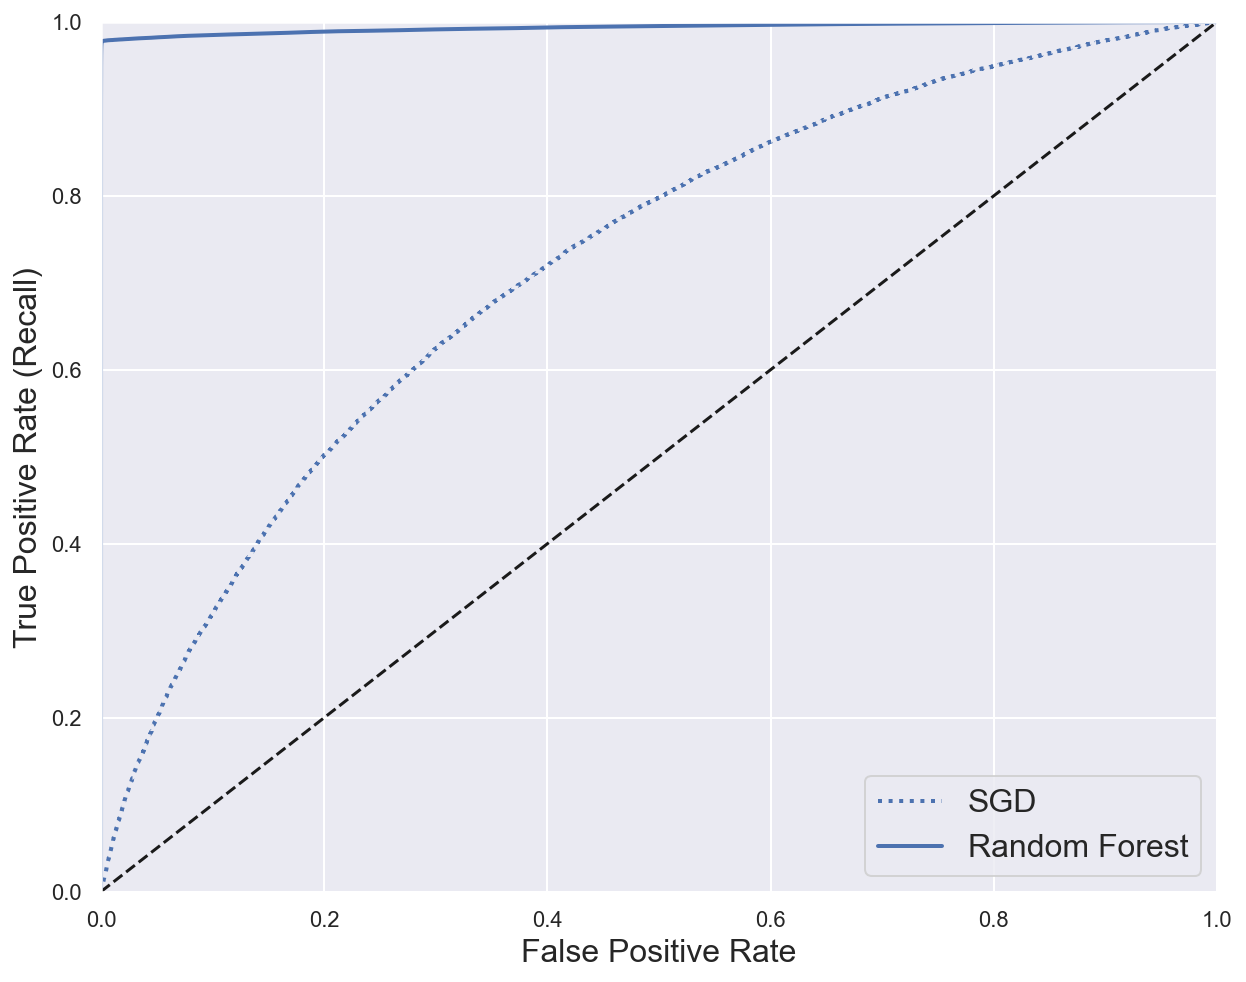

In [46]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.savefig('roc_curve_comparison_plot.png')
plt.show();

### AdaBoost

In [47]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)

In [48]:
#Train set
y_train_pred_ada = cross_val_predict(ada_clf, X_train, y_train, cv=3)
print('Precision score: ', precision_score(y_train, y_train_pred_ada))
print('Recall score: ', recall_score(y_train, y_train_pred_ada))
print('F1 score: ', f1_score(y_train, y_train_pred_ada))

Precision score:  0.6248692653418888
Recall score:  0.278048903199839
F1 score:  0.38485041042470036


In [49]:
ada_clf.fit(X_train, y_train)
print(roc_auc_score(y_train, ada_clf.predict_proba(X_train)[:,1]))

0.7632737070617461


In [50]:
#Test sets
print(roc_auc_score(y_test, ada_clf.predict_proba(X_test)[:,1]))
print(f1_score(y_test, ada_clf.predict(X_test)))

0.7568934610910838
0.27917948717948715


### XGBoost

In [51]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, 
                              eval_metric="auc", max_depth=4,learning_rate=0.277, gamma=0.382)
xgb_model.fit(X_train_rs, y_train_rs)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.382, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.277, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [52]:
print(roc_auc_score(y_train_rs, xgb_model.predict_proba(X_train_rs)[:,1]))

0.8083586709275555


In [53]:
print(f1_score(y_train_rs, xgb_model.predict(X_train_rs)))

0.46467059947928685


In [54]:
#Test sets
print(roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))
print(f1_score(y_test, xgb_model.predict(X_test)))

0.7667187881729425
0.2915388421573479


In [55]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382
                       )

eval_set=[(X_train,y_train),(X_test,y_test)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F1 score on the test set: ', f1_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test, ntree_limit=gbm.best_ntree_limit)[:, 1]))

The best number of tree:  541
F1 score on the test set:  0.29118541033434653
ROC AUC score on the test set:  0.7697344990909254


In [56]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.1, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma=0.382,
                        scale_pos_weight=6
                       )

eval_set=[(X_train,y_train),(X_test,y_test)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=True
                   )

print('The best number of tree: ', gbm.best_ntree_limit)
print('F1 score on the test set: ', f1_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)))
print('ROC AUC score on the test set: ', roc_auc_score(y_test, gbm.predict_proba(X_test, ntree_limit=gbm.best_ntree_limit)[:, 1]))

[0]	validation_0-auc:0.66843	validation_1-auc:0.67329
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.71150	validation_1-auc:0.71103
[2]	validation_0-auc:0.72693	validation_1-auc:0.72468
[3]	validation_0-auc:0.72734	validation_1-auc:0.72376
[4]	validation_0-auc:0.72725	validation_1-auc:0.72372
[5]	validation_0-auc:0.72902	validation_1-auc:0.72480
[6]	validation_0-auc:0.73196	validation_1-auc:0.72855
[7]	validation_0-auc:0.73227	validation_1-auc:0.72870
[8]	validation_0-auc:0.73269	validation_1-auc:0.72870
[9]	validation_0-auc:0.73283	validation_1-auc:0.72820
[10]	validation_0-auc:0.73348	validation_1-auc:0.72840
[11]	validation_0-auc:0.73435	validation_1-auc:0.72911
[12]	validation_0-auc:0.73509	validation_1-auc:0.72964
[13]	validation_0-auc:0.73592	validation_1-auc:0.73068
[14]	validation_0-auc:0.73809	validation_1-auc:0.73284
[15]	validation_0-auc:0.7387

[146]	validation_0-auc:0.79011	validation_1-auc:0.76322
[147]	validation_0-auc:0.79023	validation_1-auc:0.76320
[148]	validation_0-auc:0.79036	validation_1-auc:0.76318
[149]	validation_0-auc:0.79048	validation_1-auc:0.76315
[150]	validation_0-auc:0.79066	validation_1-auc:0.76319
[151]	validation_0-auc:0.79090	validation_1-auc:0.76320
[152]	validation_0-auc:0.79110	validation_1-auc:0.76319
[153]	validation_0-auc:0.79116	validation_1-auc:0.76318
[154]	validation_0-auc:0.79137	validation_1-auc:0.76314
[155]	validation_0-auc:0.79168	validation_1-auc:0.76318
[156]	validation_0-auc:0.79200	validation_1-auc:0.76331
[157]	validation_0-auc:0.79215	validation_1-auc:0.76327
[158]	validation_0-auc:0.79220	validation_1-auc:0.76321
[159]	validation_0-auc:0.79235	validation_1-auc:0.76320
[160]	validation_0-auc:0.79247	validation_1-auc:0.76320
[161]	validation_0-auc:0.79275	validation_1-auc:0.76321
[162]	validation_0-auc:0.79297	validation_1-auc:0.76328
[163]	validation_0-auc:0.79308	validation_1-auc:

ROC AUC score on the test set:  0.7641977308840873


In [57]:
fpr, tpr, thresholds

(array([0.00000000e+00, 0.00000000e+00, 1.76887835e-05, ...,
        9.99752357e-01, 9.99752357e-01, 1.00000000e+00]),
 array([0.00000000e+00, 3.77339505e-05, 3.77339505e-05, ...,
        9.99962266e-01, 1.00000000e+00, 1.00000000e+00]),
 array([  64.8733697 ,   63.8733697 ,   14.40000311, ...,   -7.7180821 ,
          -7.72593339, -134.02098886]))

In [58]:
fpr_forest, tpr_forest, thresholds_forest

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.42219589e-06,
        2.21109794e-05, 3.53775671e-05, 5.74885465e-05, 6.19107424e-05,
        8.84439177e-05, 1.23821485e-04, 1.68043444e-04, 2.21109794e-04,
        2.78598341e-04, 3.53775671e-04, 4.95285939e-04, 6.45640599e-04,
        7.69462084e-04, 9.41927724e-04, 1.14977093e-03, 1.42394708e-03,
        1.83521129e-03, 2.21109794e-03, 2.59582898e-03, 3.13091469e-03,
        3.76328870e-03, 4.49295102e-03, 5.38623459e-03, 6.328162

In [59]:
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_test, sgd_clf.decision_function(X_test))

In [60]:
#y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, forest_clf.predict_proba(X_test)[:, 1])

In [61]:
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, ada_clf.predict_proba(X_test)[:, 1])

In [62]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, gbm.predict_proba(X_test, ntree_limit=gbm.best_ntree_limit)[:, 1])

### LightGBM

In [63]:
# Modeling
import lightgbm as lgb

N_FOLDS = 5
MAX_EVALS = 5

lgb.__version__

'3.2.1'

In [64]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (305636, 250)
X_test shape:  (61503, 250)


In [65]:
#lgb requires reshaping the dataframe
y_train_lgb = np.array(y_train.astype(np.int32)).reshape((-1, ))
y_test_lgb = np.array(y_test.astype(np.int32)).reshape((-1, ))

#Crete lgb dataset
train_set_lgb = lgb.Dataset(data=X_train, label=y_train_lgb, free_raw_data=False)

type(train_set_lgb)

lightgbm.basic.Dataset

In [66]:
#Define the hyperparameters with the params that were found using the `lightgbm_params_search` notebook. 
#Oh boy it took forever

hyperparameters = {'subsample_for_bin': 60000,
 'learning_rate': 0.2849218529734569,
 'num_leaves': 100,
 'metric': 'auc',
 'boosting_type': 'dart',
 'verbose': 1,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 0.5,
 'reg_alpha': 0.836734693877551,
 'min_child_samples': 485,
 'is_unbalance': False,
 'reg_lambda': 0.7755102040816326}

hyperparameters

{'subsample_for_bin': 60000,
 'learning_rate': 0.2849218529734569,
 'num_leaves': 100,
 'metric': 'auc',
 'boosting_type': 'dart',
 'verbose': 1,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 0.5,
 'reg_alpha': 0.836734693877551,
 'min_child_samples': 485,
 'is_unbalance': False,
 'reg_lambda': 0.7755102040816326}

In [67]:
#Cross val with early stopping
cv_results = lgb.cv(hyperparameters, train_set=train_set_lgb, 
                    num_boost_round=600, metrics='auc', nfold = N_FOLDS, seed=12)
print('The cross validation score on the full dataset = {:.5f} with std: {:.5f}.'.format(
    cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('Number of estimators = {}.'.format(len(cv_results['auc-mean'])))

[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12118
[LightGBM] [Info] Number of data points in the train set: 244508, number of used features: 213
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12118
[LightGBM] [Info] Number of data points in the train set: 244509, number of used features: 213
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12118
[LightGBM] [Info] Number of data points in the train set: 244509, number of used features: 21

In [68]:
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), **hyperparameters)
import re
#X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
model.fit(X_train, y_train_lgb)

preds = model.predict_proba(X_test)[:, 1]
preds_hard = model.predict(X_test)

#Test sets

print(roc_auc_score(y_test, preds))
print(f1_score(y_test, preds_hard))

[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Info] Number of positive: 79504, number of negative: 226132
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12118
[LightGBM] [Info] Number of data points in the train set: 305636, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260126 -> initscore=-1.045312
[LightGBM] [Info] Start training from score -1.045312
0.7507430156875514
0.24858621104560222


In [69]:
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, preds)

### Extra: Multi-layer Perceptron classifier

In [70]:
from sklearn.neural_network import MLPClassifier

In [71]:
mlp_clf = MLPClassifier(random_state=42, max_iter=300, solver='lbfgs').fit(X_train, y_train)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, mlp_clf.predict_proba(X_test)[:, 1])

#Test sets
print(roc_auc_score(y_test, mlp_clf.predict_proba(X_test)[:,1]))
print(f1_score(y_test, mlp_clf.predict(X_test)))

0.6690204688022947
0.22128487994808566


### Naive Bayes

In [72]:
from sklearn.naive_bayes import BernoulliNB

In [73]:
nb = BernoulliNB()
nb.fit(X_train,y_train)
nb.score(X_test,y_test)

0.6120677040144383

In [74]:
print('F2 score for Naive Bayes: ', fbeta_score(y_test, nb.predict(X_test), 2))

F2 score for Naive Bayes:  0.33203387552090335


In [75]:
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, nb.predict_proba(X_test)[:, 1])

In [76]:
roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])

0.6462601957585936

### F2 metrics

In [77]:
print('F2 score for Log_Reg 5x: ', fbeta_score(y_test, lr_5x.predict(X_test_lr), 2))

F2 score for Log_Reg 5x:  0.31947204619595787


In [78]:
print('F2 score for KNN: ', fbeta_score(y_test, knn_pred_hard, 2))

F2 score for KNN:  0.17052246677448843


In [79]:
print('F2 score for SGD: ', fbeta_score(y_test, sgd_clf.predict(X_test), 2))

F2 score for SGD:  0.07838422697763886


In [80]:
print('F2 score for Random Forest: ', fbeta_score(y_test, forest_clf.predict(X_test), 2))

F2 score for Random Forest:  0.010572953378310341


In [81]:
print('F2 score for AdaBoost: ', fbeta_score(y_test, ada_clf.predict(X_test), 2))

F2 score for AdaBoost:  0.2766597552547059


In [82]:
print('F2 score for XGBoost: ', fbeta_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit), 2))

F2 score for XGBoost:  0.3921001229834334


In [83]:
print('F2 score for LightGBM: ', fbeta_score(y_test, preds_hard, 2))

F2 score for LightGBM:  0.22303307712237674


In [84]:
print('F2 score for MLP: ', fbeta_score(y_test, mlp_clf.predict(X_test), 2))

F2 score for MLP:  0.25096596136154553


In [85]:
print('F2 score for Naive Bayes: ', fbeta_score(y_test, nb.predict(X_test), 2))

F2 score for Naive Bayes:  0.33203387552090335


### ROC Curve

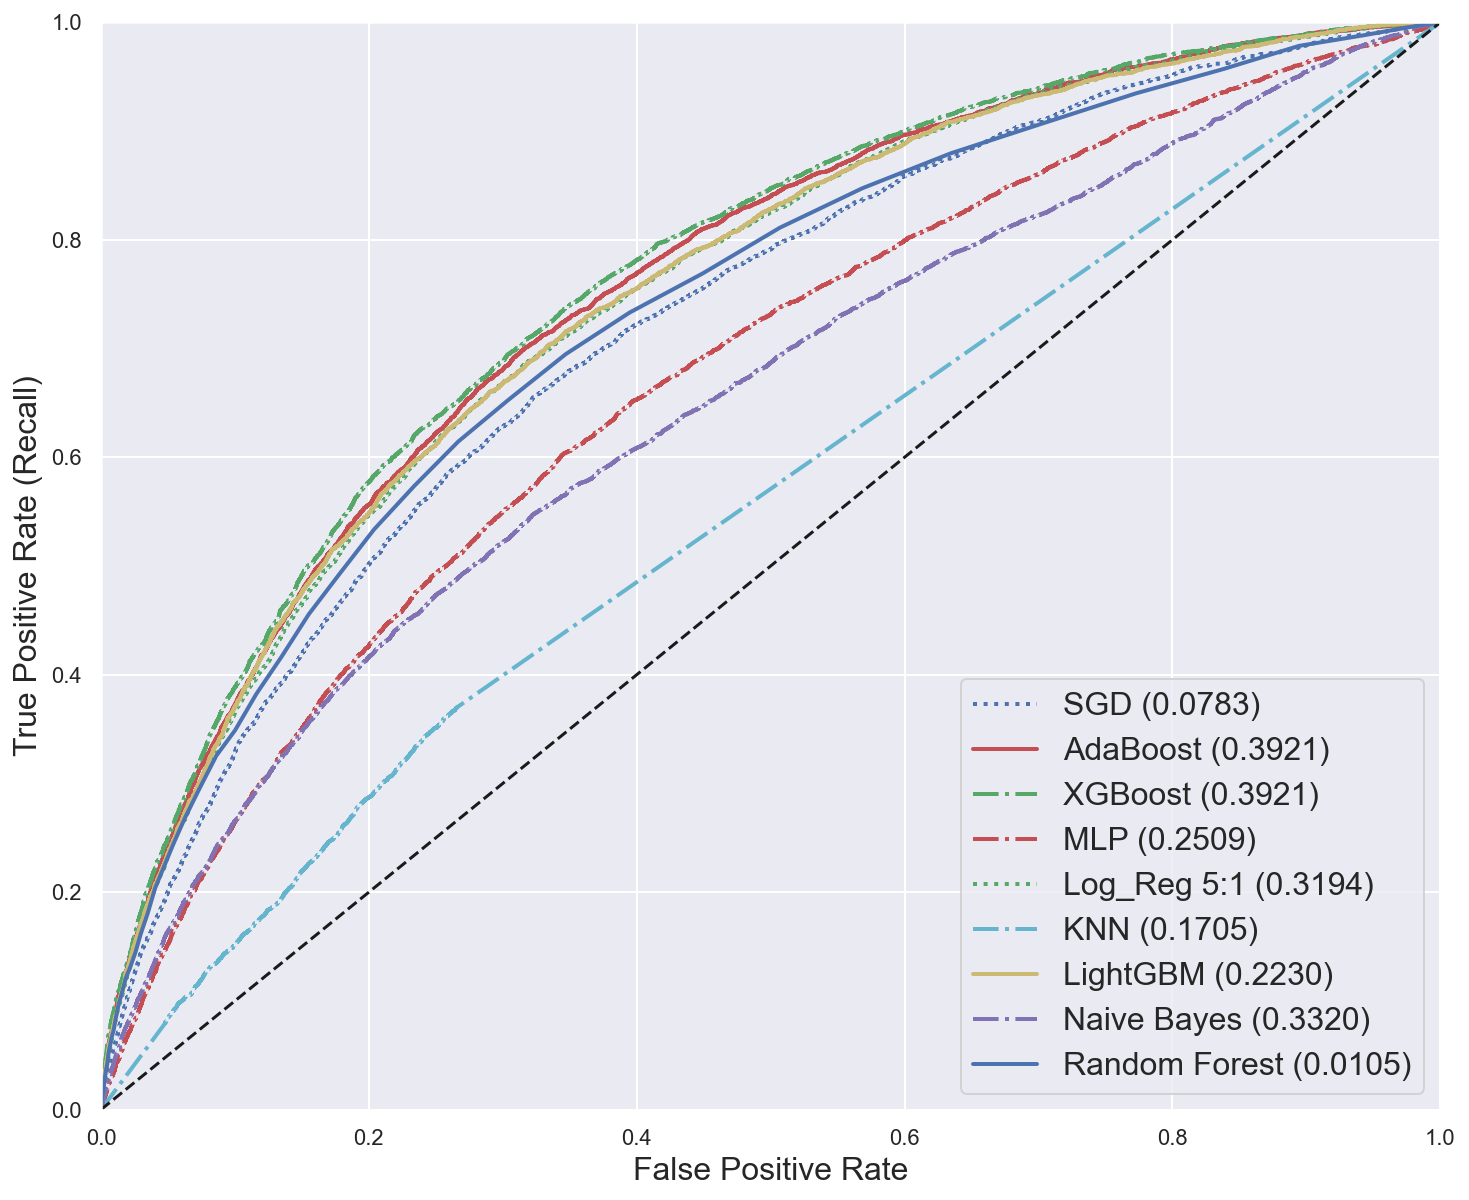

In [87]:
plt.figure(figsize=(12, 10))
plt.plot(fpr_sgd, tpr_sgd, "b:", linewidth=2, label="SGD (0.0783)")
plt.plot(fpr_ada, tpr_ada, "r-", linewidth=2, label="AdaBoost (0.3921)")
plt.plot(fpr_xgb, tpr_xgb, "g-.", linewidth=2, label="XGBoost (0.3921)")
plt.plot(fpr_mlp, tpr_mlp, "r-.", linewidth=2, label="MLP (0.2509)")
plt.plot(fpr_lr, tpr_lr, "g:", linewidth=2, label="Log_Reg 5:1 (0.3194)")
plt.plot(fpr_knn, tpr_knn, "c-.", linewidth=2, label="KNN (0.1705)")
plt.plot(fpr_lgb, tpr_lgb, "y-", linewidth=2, label="LightGBM (0.2230)")
plt.plot(fpr_nb, tpr_nb, "m-.", linewidth=2, label="Naive Bayes (0.3320)")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest (0.0105)")

plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.savefig('roc_curve_comparison_plot.png')
plt.show();